In [937]:
import pandas as pd

In [938]:
df = pd.read_excel('../../data_set/monthlyInvestigation/cleaned_monthly_investigations.xlsx')

In [939]:
import numpy as np
import pandas as pd
from xgboost import XGBClassifier
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.metrics import classification_report, confusion_matrix, f1_score
from sklearn.model_selection import GroupShuffleSplit
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import precision_recall_fscore_support

# -----------------------------
# 1. Data Preparation
# -----------------------------
df.sort_values(['Subject_ID', 'Month'], inplace=True)
df['Next_Hb'] = df.groupby('Subject_ID')['Hb (g/dL)'].shift(-1)
df['Risk_Label'] = df['Next_Hb'].apply(lambda x: 1 if x < 10 or x > 12 else 0)
df['Hb_diff'] = df['Hb (g/dL)'] - df.groupby('Subject_ID')['Hb (g/dL)'].shift(1)
df = df.dropna(subset=['Next_Hb', 'Risk_Label'])

feature_cols = [
    'Albumin (g/L)', 'BU - post HD', 'BU - pre HD', 'S Ca (mmol/L)',
    'SCR- post HD (µmol/L)', 'SCR- pre HD (µmol/L)',
    'Serum K Post-HD (mmol/L)', 'Serum K Pre-HD (mmol/L)',
    'Serum Na Pre-HD (mmol/L)', 'UA (mg/dL)', 'Hb_diff', 'Hb (g/dL)'
]

# -----------------------------
# 2. Group-aware Train-Test Split
# -----------------------------
gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
train_idx, test_idx = next(gss.split(df, groups=df['Subject_ID']))

X_train = df.iloc[train_idx][feature_cols]
y_train = df.iloc[train_idx]['Risk_Label']
X_test = df.iloc[test_idx][feature_cols]
y_test = df.iloc[test_idx]['Risk_Label']

# -----------------------------
# 3. Model 1 - Balanced Macro F1
# -----------------------------
sample_weights = compute_sample_weight(class_weight='balanced', y=y_train)
xgb_f1 = XGBClassifier(
    objective='binary:logistic',
    use_label_encoder=False,
    eval_metric='logloss',
    learning_rate=0.01,
    max_depth=5,
    n_estimators=100,
    subsample=1.0,
    colsample_bytree=1.0,
    random_state=42,
    scale_pos_weight=1.0
)
xgb_f1.fit(X_train, y_train, sample_weight=sample_weights)
y_probs_f1 = xgb_f1.predict_proba(X_test)[:, 1]

# -----------------------------
# 4. Model 2 - Boost Class 0
# -----------------------------
xgb_c0 = XGBClassifier(
    objective='binary:logistic',
    use_label_encoder=False,
    eval_metric='logloss',
    learning_rate=0.01,
    max_depth=5,
    n_estimators=100,
    subsample=1.0,
    colsample_bytree=1.0,
    random_state=42,
    scale_pos_weight=0.4  # stronger bias toward class 0 , 0.4
)
xgb_c0.fit(X_train, y_train, sample_weight=sample_weights)
y_probs_c0 = xgb_c0.predict_proba(X_test)[:, 1]

# -----------------------------
# 5. Combine Predictions (Soft Voting)
# -----------------------------
combined_probs = 0.4 * y_probs_f1 + 0.6 * y_probs_c0

# -----------------------------
# 6. Optimize Threshold for Fair Class 0 Recall
# -----------------------------
best_recall_0 = 0.5
best_thresh = 0.5

for thresh in np.linspace(0.1, 0.9, 200):
    y_pred_thresh = (combined_probs >= thresh).astype(int)
    precision, recall, f1, _ = precision_recall_fscore_support(
        y_test, y_pred_thresh, average=None, labels=[0, 1]
    )
    recall_0, recall_1 = recall
    if recall_0 > best_recall_0 and recall_1 >= 0.85:
        best_recall_0 = recall_0
        best_thresh = thresh

print(f"\n✅ Optimal blended threshold: {best_thresh:.3f}")

# -----------------------------
# 7. Final Evaluation
# -----------------------------
y_pred_final = (combined_probs >= best_thresh).astype(int)
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred_final))
print("\nClassification Report:\n", classification_report(y_test, y_pred_final))


c:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\training.py:183: UserWarning: [07:11:13] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\training.py:183: UserWarning: [07:11:13] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn


✅ Optimal blended threshold: 0.500

Confusion Matrix:
 [[29  1]
 [26 12]]

Classification Report:
               precision    recall  f1-score   support

           0       0.53      0.97      0.68        30
           1       0.92      0.32      0.47        38

    accuracy                           0.60        68
   macro avg       0.73      0.64      0.58        68
weighted avg       0.75      0.60      0.56        68



c:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

In [940]:
y_train.value_counts(), y_test.value_counts()

(Risk_Label
 1    184
 0    104
 Name: count, dtype: int64,
 Risk_Label
 1    38
 0    30
 Name: count, dtype: int64)

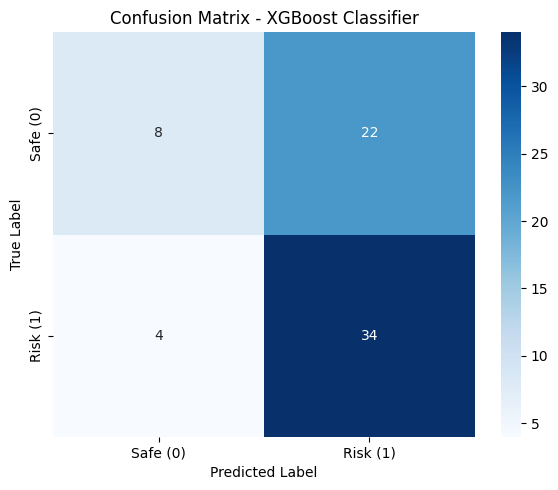


Confusion Matrix:
[[ 8 22]
 [ 4 34]]


In [941]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot Confusion Matrix
plt.figure(figsize=(6, 5))
sns.heatmap(confusion_matrix(y_test, y_pred_balanced), annot=True, fmt='d', cmap='Blues',
            xticklabels=['Safe (0)', 'Risk (1)'],
            yticklabels=['Safe (0)', 'Risk (1)'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix - XGBoost Classifier')
plt.tight_layout()
plt.show()

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred_balanced))


ValueError: x and y must have same first dimension, but have shapes (200,) and (1000,)

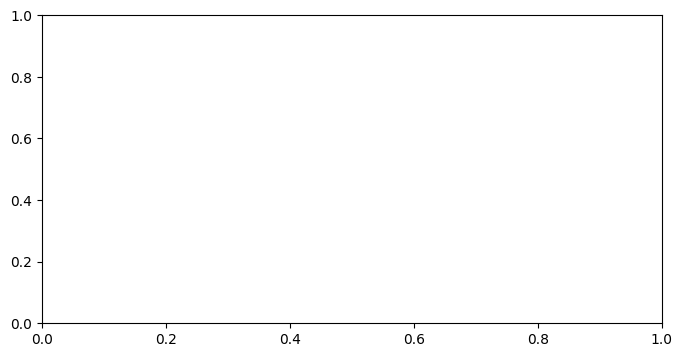

In [942]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 4))
plt.plot(thresholds, precisions_0, label='Precision for Class 0')
plt.xlabel("Threshold")
plt.ylabel("Precision")
plt.title("Precision vs Threshold (Class 0)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


AUC Score: 0.72


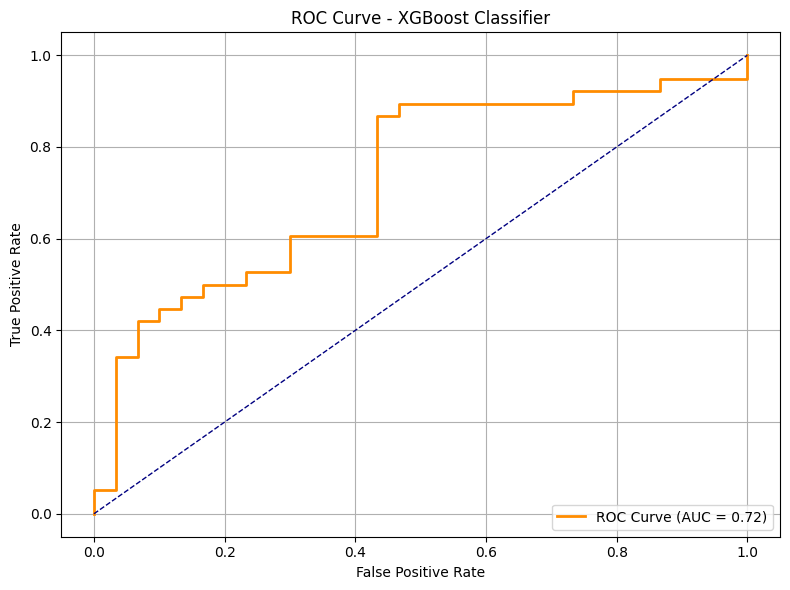

In [ ]:
from sklearn.metrics import roc_auc_score, roc_curve, RocCurveDisplay
import matplotlib.pyplot as plt

y_test_proba = xgb_model.predict_proba(X_test)[:, 1]

# Compute AUC score
auc_score = roc_auc_score(y_test, y_test_proba)
print(f"AUC Score: {auc_score:.2f}")

# Compute ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_test_proba)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC Curve (AUC = {auc_score:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - XGBoost Classifier')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_predict
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import precision_recall_curve, average_precision_score
import numpy as np

## 1. Enhanced Base Models
# Create more diverse base models
estimators = [
    ('xgb1', XGBClassifier(
    scale_pos_weight=y_train.value_counts()[0] / y_train.value_counts()[1],
    eval_metric='logloss',
    use_label_encoder=False,
    random_state=42,
    learning_rate=0.1,
)),
    # ('xgb1', XGBClassifier(
    #     max_depth=3,
    #     learning_rate=0.01,
    #     subsample=0.8,
    #     colsample_bytree=0.8,
    #     gamma=0.1,
    #     random_state=42,
    #     scale_pos_weight=0.005,
    # )),
    # ('xgb2', XGBClassifier(
    #     max_depth=3,
    #     learning_rate=0.1,
    #     min_child_weight=3,
    #     reg_alpha=0.1,
    #     random_state=42
    # )),
    # ('rf', RandomForestClassifier(
    #     n_estimators=100,
    #     max_depth=5,
    #     class_weight='balanced',
    #     random_state=42
    # ))
]

## 2. Improved Meta-Learner
# Use calibrated classifier for better probability estimates
calibrated_lr = CalibratedClassifierCV(
    LogisticRegression(class_weight='balanced', max_iter=100),
    method='isotonic',
    cv=3
)

## 3. Enhanced Stacking Classifier
stack = StackingClassifier(
    estimators=estimators,
    final_estimator=calibrated_lr,
    cv=3,
    stack_method='predict_proba',  # Use probabilities instead of hard predictions
    n_jobs=-1  # Parallelize computation
)

## 4. Train with Class Weights
# Compute sample weights
sample_weights = compute_sample_weight(class_weight='balanced', y=y_train)
stack.fit(X_train, y_train, sample_weight=sample_weights)

## 5. Optimal Threshold Finding (Medical Context)
# Get calibrated probabilities from stacked model
y_probs = stack.predict_proba(X_test)[:, 1]

# Find threshold that maximizes F1-score for class 1 (risk)
precision, recall, thresholds = precision_recall_curve(y_test, y_probs)
f1_scores = 2 * (precision * recall) / (precision + recall + 1e-8)
optimal_idx = np.argmax(f1_scores)
optimal_threshold = thresholds[optimal_idx]

print(f"Optimal decision threshold: {optimal_threshold:.3f}")

# Apply optimal threshold
y_pred = (y_probs >= optimal_threshold).astype(int)

## 6. Evaluation
print("\nEnhanced Stacking Classifier Performance:")
print(classification_report(y_test, y_pred))
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

# Calculate and display average precision
ap_score = average_precision_score(y_test, y_probs)
print(f"\nAverage Precision Score: {ap_score:.3f}")

Optimal decision threshold: 0.458

Enhanced Stacking Classifier Performance:
              precision    recall  f1-score   support

           0       0.68      0.70      0.69        30
           1       0.76      0.74      0.75        38

    accuracy                           0.72        68
   macro avg       0.72      0.72      0.72        68
weighted avg       0.72      0.72      0.72        68


Confusion Matrix:
[[21  9]
 [10 28]]

Average Precision Score: 0.741
